# Install torch and download the dataset

In [ ]:
!pip install torch
!pip install torch-geometric
!pip install node2vec


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.4 MB/s eta 0:00:00


In [ ]:
import torch
import os
import urllib.request

# Step 1: Download the Facebook Ego dataset
url = "https://snap.stanford.edu/data/facebook_combined.txt.gz"
dataset_path = "facebook_combined.txt.gz"

if not os.path.exists(dataset_path):
    urllib.request.urlretrieve(url, dataset_path)
    print("Facebook dataset downloaded.")



Facebook dataset downloaded.



# Data analysis

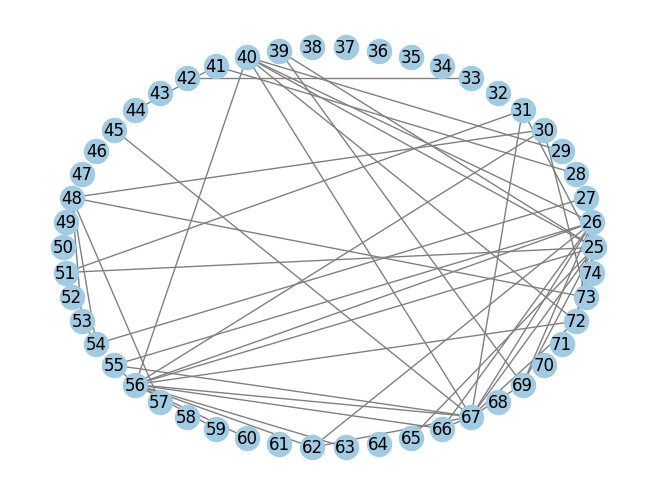

In [ ]:
import networkx as nx
import matplotlib.pylab as plt

# Load the original graph from the edge list
graph = nx.read_edgelist('facebook_combined.txt.gz', delimiter=' ', create_using=nx.Graph(), nodetype=int)

# Get the first 50 nodes
subgraph = list(graph.nodes())[25:75]

# Create a subgraph with only those 50 nodes
subgraph = graph.subgraph(subgraph)

# Generate the layout for the subgraph
pos = pos = nx.circular_layout(subgraph)
# Draw the subgraph
nx.draw(subgraph, pos, node_color='#A0CBE2', edge_color='#808080', width=1, edge_cmap=plt.cm.Blues, with_labels=True, arrows=False)

# Show the plot
plt.show()

In [ ]:
print("The number of unique persons",len(graph.nodes()))

The number of unique persons 4039


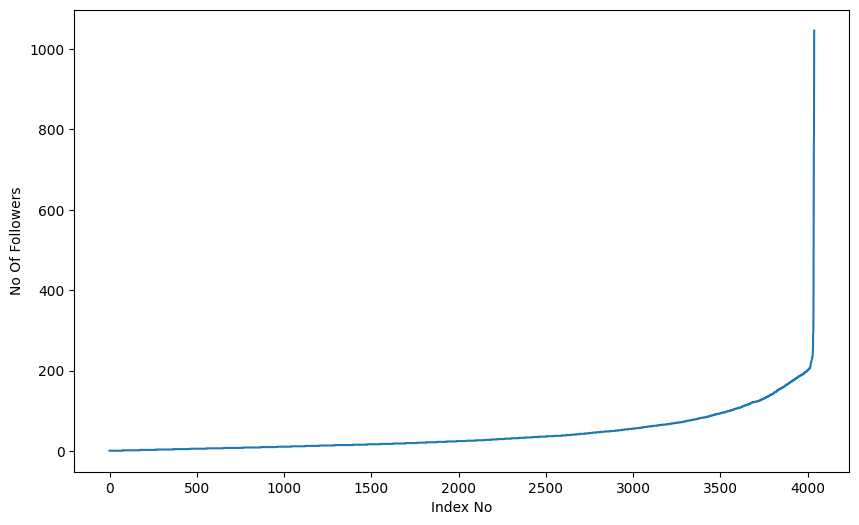

In [ ]:
degree_dist = list(dict(graph.degree()).values())
degree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(degree_dist)
plt.xlabel('Index No')
plt.ylabel('No Of Followers')
plt.show()

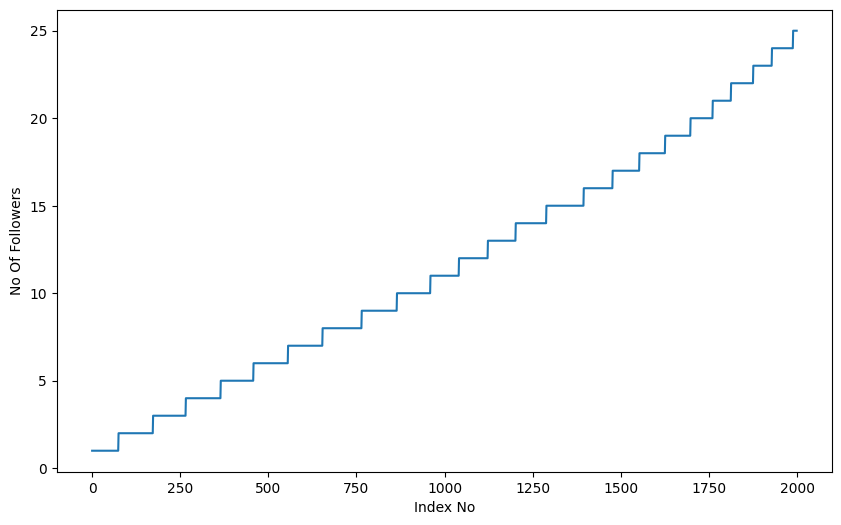

In [ ]:
# let's zoom in
degree_dist = list(dict(graph.degree()).values())
degree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(degree_dist[0:2000])
plt.xlabel('Index No')
plt.ylabel('No Of Followers')
plt.show()

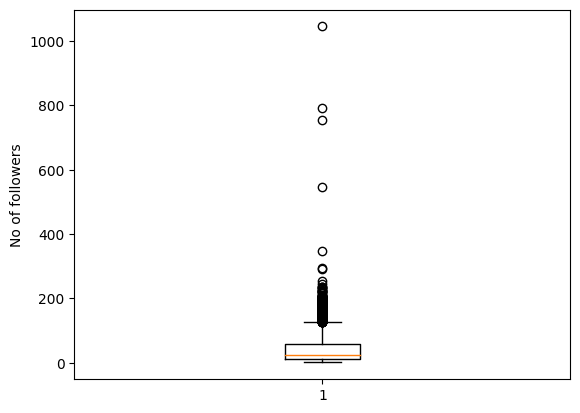

In [ ]:
plt.boxplot(degree_dist)
plt.ylabel('No of followers')
plt.show()

In [ ]:
import numpy as np
# 0 and 90-100 percentile
print(0, "percentile value is", np.percentile(degree_dist,0))
for i in range(0,11):
  print(90+i, "percentile value is", np.percentile(degree_dist,90+i))

0 percentile value is 1.0
90 percentile value is 112.20000000000027
91 percentile value is 119.0
92 percentile value is 124.0
93 percentile value is 132.0
94 percentile value is 141.0
95 percentile value is 153.0999999999999
96 percentile value is 164.0
97 percentile value is 176.0
98 percentile value is 187.0
99 percentile value is 199.6199999999999
100 percentile value is 1045.0


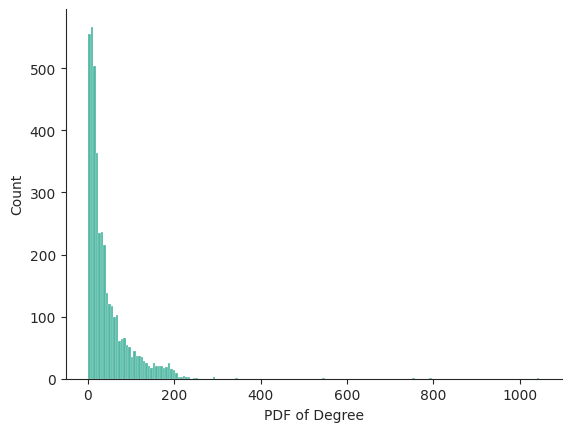

In [ ]:
import seaborn as sns
%matplotlib inline
sns.set_style('ticks')
fig, ax = plt.subplots()
sns.histplot(degree_dist, color='#16A085')
plt.xlabel('PDF of Degree')
sns.despine()
plt.show()

# Data preprocessing

In [ ]:
import zipfile
# Step 2: Preprocess the data - Create edge list
import gzip

edges = []
with gzip.open(dataset_path, 'rt') as f:
    for line in f:
        src, dst = map(int, line.strip().split())
        edges.append([src, dst])
edges_list = edges
from collections import Counter
degrees = Counter([edge[0] for edge in edges_list] + [edge[1] for edge in edges_list])

In [ ]:
edges_list = edges
print(len(edges_list))
edges_list = [edge for edge in edges_list if edge[0] != edge[1]]
edges_list = list(set([tuple(sorted(edge)) for edge in edges_list]))
# remove nodes (and their edges) that have a degree below 2
edges_list = [edge for edge in edges_list if degrees[edge[0]] > 1 and degrees[edge[1]] > 1]
print(len(edges_list))
# remove top 1% of nodes with highest degrees
high_degree_threshold = 0.99
threshold = np.percentile(list(degrees.values()), 99)
edges_list = [edge for edge in edges_list if degrees[edge[0]] < threshold and degrees[edge[1]] < threshold]
print(len(edges_list))

88234
88159
77147


# Creating and training the model

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, global_mean_pool  # Global pooling
from sklearn.model_selection import train_test_split
from torch_geometric.nn import BatchNorm
from node2vec import Node2Vec
from sklearn.model_selection import train_test_split

import torch

# Check if GPU is available and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


edges_copy = edges_list
torch_edges = torch.tensor(edges_copy, dtype=torch.long).t().contiguous()
# Number of nodes
num_nodes = torch_edges.max().item() + 1

# Create node features based on node degree
node_degrees = torch.tensor([degrees[node] for node in range(num_nodes)], dtype=torch.float)

# Reshape node features to have them as a feature vector (degree as a single feature)
x = node_degrees.view(-1, 1)

# Calculate the average clustering coefficient
avg_clustering_coeff = nx.average_clustering(graph)

# Add the average clustering coefficient as a feature for every node
avg_clustering_tensor = torch.full((num_nodes, 1), avg_clustering_coeff, dtype=torch.float)

# Append the feature to the existing node features
x = torch.cat([x, avg_clustering_tensor], dim=1)

# Add the diameter as a feature for each node
graph_diameter = 8  # based on the dataset information
diameter_tensor = torch.full((num_nodes, 1), graph_diameter, dtype=torch.float)

# Add the diameter as a feature to each node
x = torch.cat([x, diameter_tensor], dim=1)


# Initialize the Node2Vec model
node2vec = Node2Vec(graph, dimensions=64, walk_length=30, num_walks=200, workers=1)

# Fit the model to generate embeddings
model = node2vec.fit(window=5, min_count=1)
#print(len(model.wv))  # Should match the number of nodes in the graph
#print(num_nodes)      # Should also match the number of nodes in the graph
# Get embeddings for all nodes
embeddings = [model.wv[str(node)] for node in range(num_nodes)]

# Convert embeddings to a tensor
embedding_tensor = torch.tensor(embeddings, dtype=torch.float)

# Concatenate the embeddings to the existing feature matrix
x = torch.cat([x, embedding_tensor], dim=1)

# Update the Data object with the new feature matrix
data = Data(x=x, edge_index=torch_edges)

print(f"Node features based on degree: {data.x[:5]}")

# Step 5: Create labels for friend recommendation
# Positive samples (existing edges)
positive_edges = torch.tensor(edges_copy, dtype=torch.long).t().contiguous()

# Generate negative samples
num_nodes = torch_edges.max().item() + 1
negative_edges = []
while len(negative_edges) < len(positive_edges[0]) // 2:  # Half the size of positive edges
    src = torch.randint(0, num_nodes, (1,)).item()
    dst = torch.randint(0, num_nodes, (1,)).item()
    if src != dst and (src, dst) not in edges_list and (dst, src) not in edges_list:
        negative_edges.append([src, dst])

# Combine positive and negative edges
all_edges = torch.cat([positive_edges, torch.tensor(negative_edges, dtype=torch.long).t()], dim=1)
all_labels = torch.cat([torch.ones(positive_edges.size(1)), torch.zeros(len(negative_edges))])  # Labels for edges

train_edges, test_edges, train_labels, test_labels = train_test_split(all_edges.t(), all_labels, test_size=0.2, random_state=42)

# Create Data objects for training and testing
train_data = Data(x=x, edge_index=train_edges.t().contiguous(), y=train_labels)
test_data = Data(x=x, edge_index=test_edges.t().contiguous(), y=test_labels)

# Step 6: Create DataLoader for edge classification
from torch_geometric.data import DataLoader


Computing transition probabilities:   0%|          | 0/4039 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 200/200 [06:13<00:00,  1.87s/it]
<ipython-input-14-b5fedbf60e73>:55: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  embedding_tensor = torch.tensor(embeddings, dtype=torch.float)


Node features based on degree: tensor([[ 3.4700e+02,  6.0555e-01,  8.0000e+00,  5.3497e-01, -8.3613e-01,
          4.4488e-03,  3.9827e-01,  3.6120e-01, -7.3019e-01, -5.2574e-01,
         -4.4022e-02,  3.0625e-01,  4.1471e-03,  4.2826e-01,  2.5465e-01,
         -6.1666e-02,  1.3209e-01,  2.5828e-01,  8.9700e-01, -4.2245e-01,
          2.4061e-01, -4.8658e-01,  4.5010e-01,  1.0587e+00,  7.5750e-01,
          6.9692e-03, -1.2368e+00, -5.1645e-02,  3.9763e-01, -6.2860e-01,
          6.4365e-01, -6.6138e-01, -6.5590e-01, -2.4942e-02, -8.0585e-02,
          4.5967e-01,  1.7771e-01,  8.0559e-01,  2.7834e-02, -5.5632e-01,
         -1.0021e-01,  4.5548e-01, -3.3030e-02, -1.3195e-01,  1.8483e-01,
         -2.4733e-01, -1.2420e-01, -1.8965e-01, -3.7474e-01, -4.0953e-02,
          4.4684e-02,  2.1752e-01,  2.7567e-01,  3.0655e-01, -3.2394e-01,
          6.4990e-01,  7.2208e-02,  2.9417e-01, -8.5656e-02,  2.8627e-02,
         -2.1965e-01, -7.5033e-01,  4.6897e-01, -6.1825e-01, -3.7362e-01,
       

In [ ]:
# Define a modified GCN model for edge classification
class GCNEdgeClassification(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, dropout=0.25):
        super(GCNEdgeClassification, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.fc = torch.nn.Linear(hidden_channels, 2)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv4(x, edge_index)
        x = F.relu(x)

        # Implement edge-based classification
        edge_embeddings = x[edge_index[0]] + x[edge_index[1]]  # Combine source and target node embeddings
        x = self.fc(edge_embeddings)
        return F.log_softmax(x, dim=1)  # Adjust for edge-based output

# Initialize the model and optimizer
model = GCNEdgeClassification(in_channels=x.size(1), hidden_channels=128, dropout=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop adapted for edge classification
def train_edge_classification():
    model.train()
    optimizer.zero_grad()
    out = model(train_data)
    loss = F.nll_loss(out, train_data.y.long())  # Ensure data.y is the correct shape
    loss.backward()
    optimizer.step()
    return loss.item()

def test_edge_classification():
    model.eval()
    with torch.no_grad():
        pred = model(test_data).argmax(dim=1)
        correct = (pred == test_data.y).sum()  # Check if predicted edges match actual labels
        acc = int(correct) / test_data.y.size(0)
        return acc

# Training the model for friend recommendation
for epoch in range(1, 2401):
    loss = train_edge_classification()
    if epoch % 20 == 0:
        acc = test_edge_classification()
        print(f'Epoch {epoch}, Loss: {loss:.4f}, Test Accuracy: {acc:.4f}')


Epoch 20, Loss: 0.5952, Test Accuracy: 0.6753
Epoch 40, Loss: 0.5887, Test Accuracy: 0.6806
Epoch 60, Loss: 0.5804, Test Accuracy: 0.6845
Epoch 80, Loss: 0.5745, Test Accuracy: 0.6898
Epoch 100, Loss: 0.5685, Test Accuracy: 0.6880
Epoch 120, Loss: 0.5725, Test Accuracy: 0.6905
Epoch 140, Loss: 0.5655, Test Accuracy: 0.6899
Epoch 160, Loss: 0.5646, Test Accuracy: 0.6904
Epoch 180, Loss: 0.5657, Test Accuracy: 0.6911
Epoch 200, Loss: 0.5635, Test Accuracy: 0.6924
Epoch 220, Loss: 0.5625, Test Accuracy: 0.6915
Epoch 240, Loss: 0.5598, Test Accuracy: 0.6937
Epoch 260, Loss: 0.5586, Test Accuracy: 0.6916
Epoch 280, Loss: 0.5599, Test Accuracy: 0.6937
Epoch 300, Loss: 0.5574, Test Accuracy: 0.6926
Epoch 320, Loss: 0.5566, Test Accuracy: 0.6927
Epoch 340, Loss: 0.5577, Test Accuracy: 0.6891
Epoch 360, Loss: 0.5584, Test Accuracy: 0.6940
Epoch 380, Loss: 0.5622, Test Accuracy: 0.6969
Epoch 400, Loss: 0.5584, Test Accuracy: 0.6953
Epoch 420, Loss: 0.5573, Test Accuracy: 0.6985
Epoch 440, Loss: 